In [ ]:
MODEL_CLASS = "MLNet"
DATA_NAME = "lastfm"
MODEL_NAME = f"{MODEL_CLASS}_{DATA_NAME}"
LEARNING_TYPE = "pairwise"
TRN_NEG_PER_POS = 1
TRN_BATCH_SIZE = 256

# WORK_DIR_PATH = "../.."

from google.colab import drive
drive.mount('/content/drive')
WORK_DIR_PATH = "/content/drive/MyDrive/RS-DeepCF/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constants

In [ ]:
# split
EVAL_NEG_PER_POS = 99
EVAL_BATCH_SIZE = 1000
DATA_LOADING_TYPE = "general"
FILTER_BY = "user"
TRN_VAL_TST_RATIO = [0.8, 0.1, 0.1]
NEG_PER_POS = [TRN_NEG_PER_POS, TRN_NEG_PER_POS, EVAL_NEG_PER_POS, EVAL_NEG_PER_POS]
BATCH_SIZE = [TRN_BATCH_SIZE, TRN_BATCH_SIZE, EVAL_BATCH_SIZE, EVAL_BATCH_SIZE]
MAX_HIST = None
SHUFFLE = False if DATA_LOADING_TYPE=="curriculum" else True

# Model
N_FACTORS = 32
HIDDEN_RL = [N_FACTORS*4, N_FACTORS*2, N_FACTORS, N_FACTORS // 2]
HIDDEN_ML = [N_FACTORS*2, N_FACTORS*2, N_FACTORS, N_FACTORS // 2]
DROPOUT = 0.2

# how to learn
LEARNING_RATE = 1e-4 if TRN_BATCH_SIZE==256 else 1e-3
LAMBDA_ = 1e-3

# how to monitor
PATIENCE = 5
MIN_DELTA = 1e-3

# how to loop
N_EPOCHS = 1000
INTERVAL = 5

# Config

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: /content/drive/.shortcut-targets-by-id/1e1TqQlbrL1-f0bSjBw1RbEj5bEo-SeAX/RS-DeepCF


In [12]:
import pandas as pd
import torch
from DeepCF import deepcf
import UTILS
from LOOP.loop import TrainingLoop
from LOOP.monitor.predictor import predict
from LOOP.monitor.monitor import EarlyStoppingMonitor
from LOOP.metric.ranking import ndcg_at_k as metric_fn
from LOOP.metric.ranking import top_k_loop

In [ ]:
if LEARNING_TYPE=="pairwise":
    from DATA_SPLITTER.pairwise import trn_val_tst
    from LOOP.trainer.pairwise import PairwiseTrainer as Trainer
    from LOOP.loss_fn.bpr import bpr as task_fn

elif LEARNING_TYPE=="pointwise":
    from DATA_SPLITTER.pointwise import trn_val_tst
    from LOOP.trainer.pointwise import PointwiseTrainer as Trainer
    from LOOP.loss_fn.bce import bce as task_fn

else:
    ValueError

In [14]:
from UTILS.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    COL_DICT,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
    SEED,
)

In [15]:
# seed
UTILS.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [16]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [ ]:
data = pd.read_csv(f"./_data/{DATA_NAME}.csv")

In [20]:
# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [21]:
# data Description
UTILS.data_handler.description(data)

number of user: 1892
number of item: 17632
total interaction: 92834
interaction density: 0.2783 %
max interaction of user: 50
top 10.0 % interaction of user: 50.0
mean interaction of user: 49
mean interaction of item: 5


In [22]:
kwargs = dict(
    origin=data,
    n_users=N_USERS,
    n_items=N_ITEMS,
    loading_type=DATA_LOADING_TYPE,
)

dataloader = trn_val_tst.DataSplitter(**kwargs)

In [23]:
kwargs = dict(
    filter_by=FILTER_BY,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos=NEG_PER_POS,
    batch_size=BATCH_SIZE,
    max_hist=MAX_HIST,
    shuffle=SHUFFLE,
)

loaders, interactions, histories = dataloader.get(**kwargs)

In [24]:
trn_loader, val_loader, tst_loader, loo_loader = loaders

# Modeling

In [ ]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
    dropout=DROPOUT,
    interactions=interactions,
)

if MODEL_CLASS=="CFNet":
    kwargs["hidden_rl"] = HIDDEN_RL
    kwargs["hidden_ml"] = HIDDEN_ML
    model = deepcf.cfnet.Module(**kwargs)
elif MODEL_CLASS=="MLNet":
    kwargs["hidden"] = HIDDEN_ML
    model = deepcf.mlnet.Module(**kwargs)
elif MODEL_CLASS=="RLNet":
    kwargs["hidden"] = HIDDEN_RL
    model = deepcf.rlnet.Module(**kwargs)
else:
    ValueError

In [26]:
kwargs = dict(
    model=model,
    task_fn=task_fn,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_
)

trainer = Trainer(**kwargs)

In [27]:
kwargs = dict(
    model=model,
    metric_fn=metric_fn,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

monitor = EarlyStoppingMonitor(**kwargs)

In [28]:
kwargs = dict(
    model=model,
    trainer=trainer,
    monitor=monitor,
)

loop = TrainingLoop(**kwargs)

# Train

In [29]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    loo_loader=loo_loader,
    n_epochs=N_EPOCHS,
    interval=INTERVAL,
)

history = loop.fit(**kwargs)

LEAVE ONE OUT BEST EPOCH: 55
LEAVE ONE OUT BEST SCORE (ndcg@10): 0.5828
MEAN OF PER EPOCH (/s): 4.0347


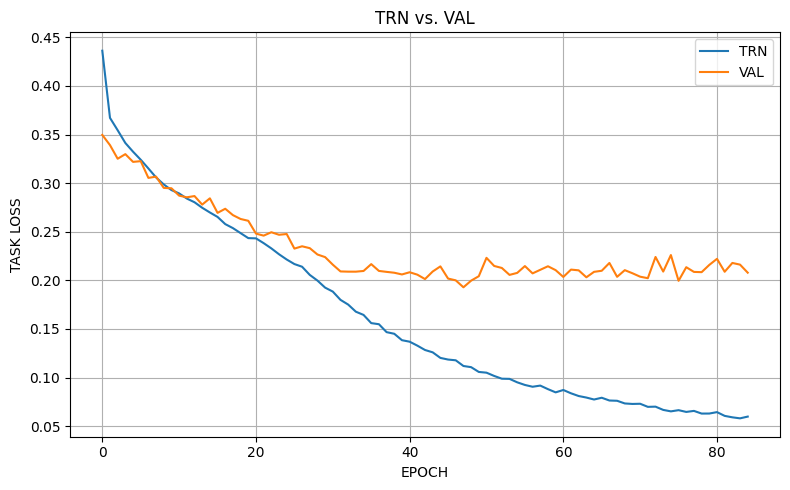

In [30]:
UTILS.visualizer.loss_plot(history, 'TASK LOSS')

# Test

In [31]:
kwargs = dict(
    model=model,
    dataloader=tst_loader,
)

result = predict(**kwargs)

TST: 100%|██████████| 928/928 [00:07<00:00, 123.10it/s]


In [32]:
eval = top_k_loop(result)
eval

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.898188,0.371748,0.376093,0.288932,0.416086
1,10,0.951493,0.260501,0.526777,0.349308,0.498285
2,15,0.971215,0.198010,0.600880,0.369232,0.531315
3,20,0.978678,0.159941,0.647068,0.378427,0.549760
4,25,0.982942,0.134328,0.679016,0.383643,0.561604
5,50,0.995203,0.076151,0.770531,0.393301,0.591240
6,100,1.000000,0.042527,0.861461,0.398168,0.615900


# Save

In [ ]:
PATH = f'./_checkpoints/{LEARNING_TYPE}_{INTERVAL}_{TRN_BATCH_SIZE}/{MODEL_NAME}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save(**kwargs)